In [21]:
import warnings

import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import statsmodels as sm
import tensorflow as tf
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa import api as smt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller


import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
# import pmdarima as pm
import tensorflow as tf
import xgboost as xgb
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from rich.progress import track
import numpy as np
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import STLForecast

# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
rcParams['figure.figsize'] = 18, 8
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

In [22]:
user_balance = pd.read_csv("user_balance_table.csv")
user_balance['report_date'] = pd.to_datetime(user_balance['report_date'], format='%Y%m%d')

user_balance.sort_values(by='report_date', inplace=True)

data = user_balance.groupby(['report_date']).sum()
train_data = data.iloc[273:396]
test_data = data.iloc[396:427]

In [23]:
def get_score(purchase_pred, redeem_pred, purchase_true, redeem_true, h=0.3):
    purchase_mape = np.abs(purchase_pred - purchase_true) / purchase_true
    redeem_mape = np.abs(redeem_pred - redeem_true) / redeem_true

    score = np.sum(np.exp(-purchase_mape / h) * 10) * 0.45 + np.sum(np.exp(-redeem_mape / h) * 10) * 0.55
    return score

In [24]:
#### STL ####
# Purchase
purchase_ts = train_data["total_purchase_amt"]
purchase_ts.index = pd.DatetimeIndex(purchase_ts.index.values,freq=purchase_ts.index.inferred_freq)
purchase_stl = STLForecast(purchase_ts, ARIMA, robust = True).fit()
purchase_pred_test_stl = purchase_stl.forecast(31)

# Redeem
redeem_ts = train_data["total_redeem_amt"]
redeem_ts.index = pd.DatetimeIndex(redeem_ts.index.values,freq=redeem_ts.index.inferred_freq)
redeem_stl = STLForecast(redeem_ts, ARIMA, robust = True).fit()
redeem_pred_test_stl = redeem_stl.forecast(31)

# If your data is really periodic and you don't have gaps in your time series, then pandas can infer the frequency.

get_score(purchase_pred_test_stl, redeem_pred_test_stl, test_data["total_purchase_amt"], test_data["total_redeem_amt"])

180.56745684926182

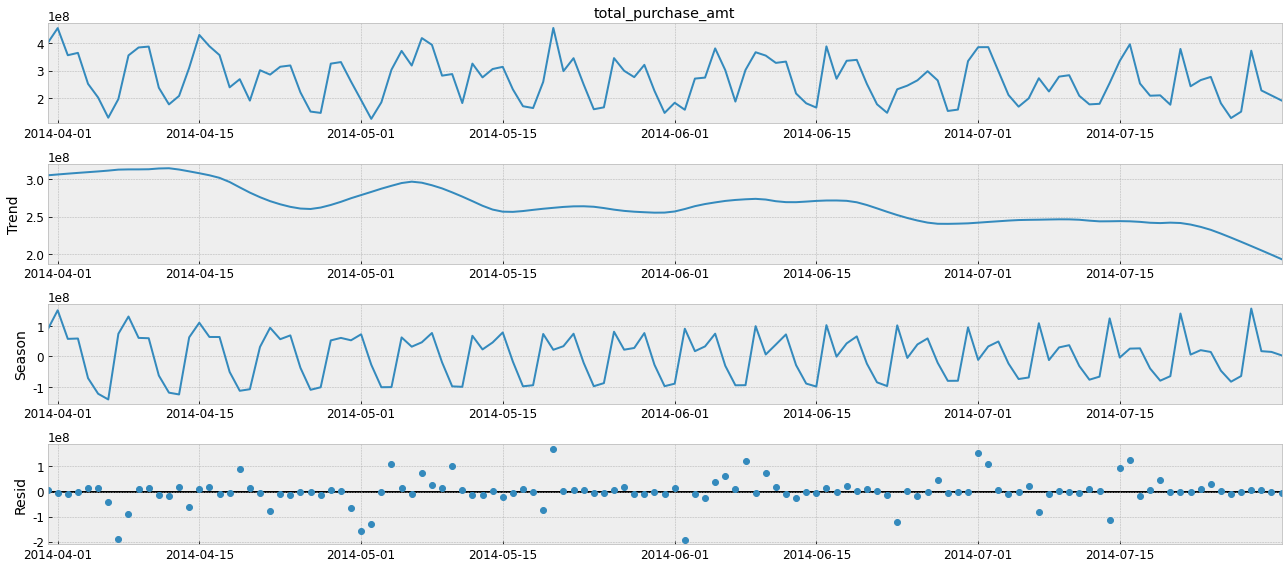

In [25]:
purchase_stl_res = STL(purchase_ts,robust = True).fit()
purchase_stl_res.plot()
plt.show()

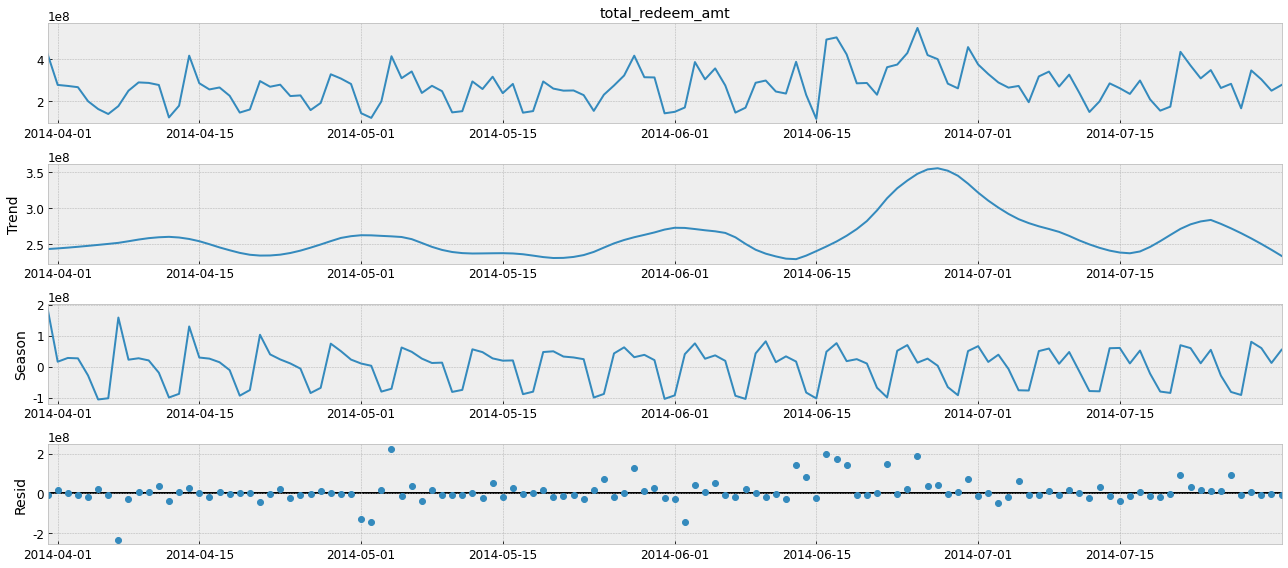

In [26]:
redeem_stl_res = STL(redeem_ts,robust = True).fit()
redeem_stl_res.plot()
plt.show()

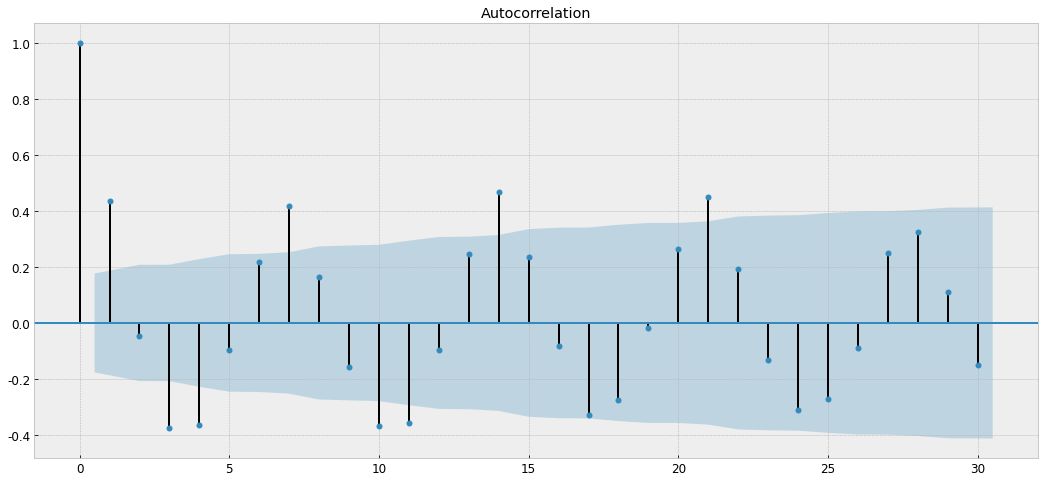

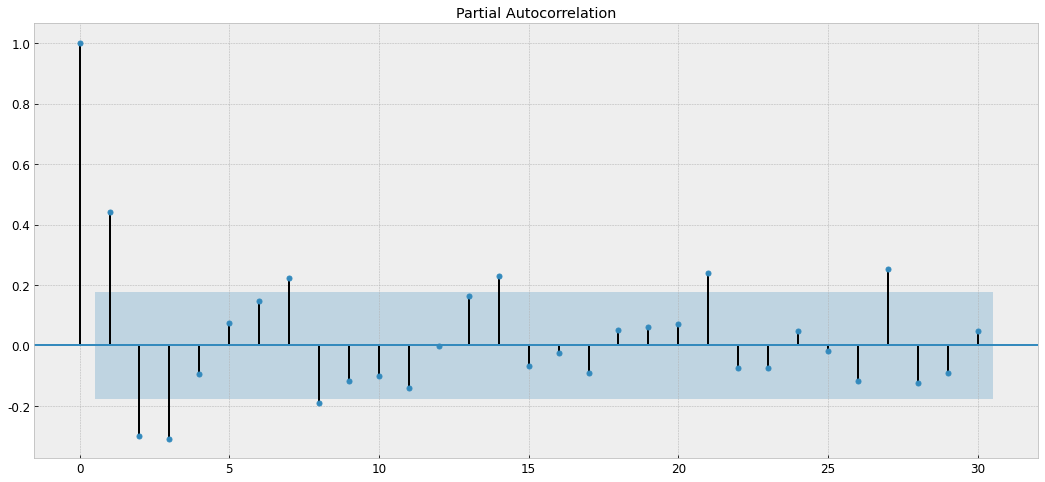

In [27]:
plot_acf(purchase_ts, lags=30)
plot_pacf(purchase_ts, lags=30)
plt.show()

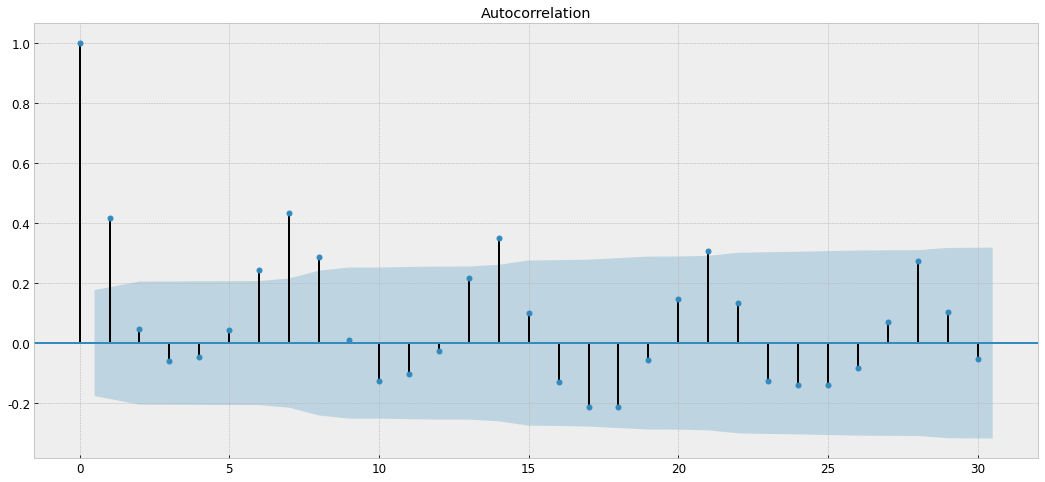

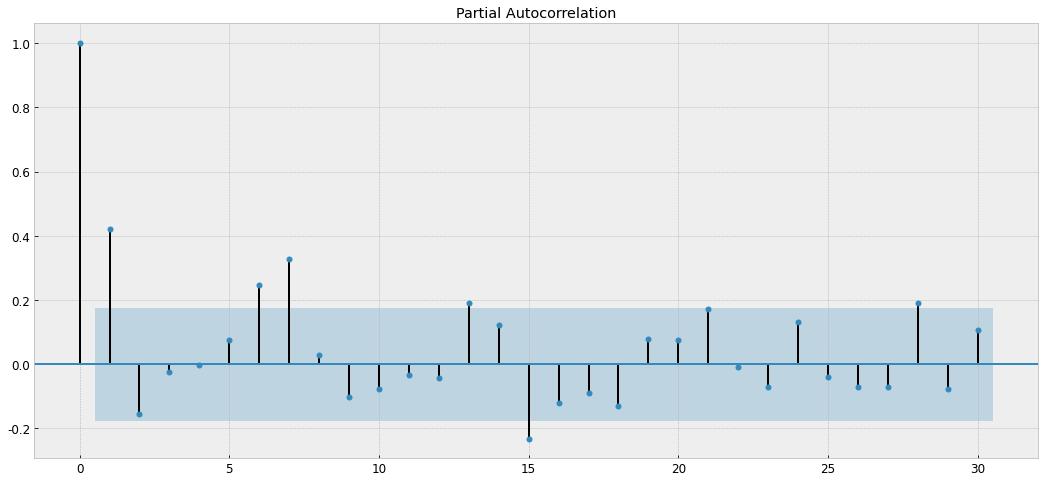

In [28]:
plot_acf(redeem_ts, lags=30)
plot_pacf(redeem_ts, lags=30)
plt.show()

In [29]:
# IPython
from IPython.display import IFrame
IFrame(width="853",height="480",src = "https://www.youtube.com/embed/1opjnegd_hA")

In [30]:
X = purchase_ts
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.071761
p-value: 0.256020
Critical Values:
	1%: -3.492
	5%: -2.888
	10%: -2.581


可以看到 p-value: 0.694411 是大于 0.05的，所以接受原假设H0，意味着序列是不平稳的。

In [31]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(purchase_ts, lags = [7,15,30],boxpierce=True)

(array([ 90.29304491, 181.4575283 , 319.16939849]),
 array([1.07713617e-16, 1.20810495e-30, 4.30831870e-50]),
 array([ 86.01725419, 166.84858722, 277.41167936]),
 array([8.11488380e-16, 1.04790861e-27, 7.17069497e-42]))

由输出结果可以看到，不管是使用哪个统计量，p值都很小，所以该数据拒绝原假设，即认为该数据不是纯随机数据。